In [33]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from multiprocessing import Pool
from rdkit.Chem import EnumerateStereoisomers
import pandas as pd 
from tqdm import tqdm 
smiles = pd.read_csv("/a/scratch/alexm/research/gdb/gdb13/gdb13.cno._00.csv", header=None) # this took 5s to load? 
smiles = smiles[0].values

In [29]:
smiles.shape 

(5571822,)

In [49]:
# count hydrogens and flippers 
# make this into a script and just run it a shit ton of times. 
# flippers are the ones we use to sort before doing somers to have load balancing for parallel processing. 

# all of this string stuff; if we tilejax this basic cheminformatics one IPU could do this 
from rdkit.Chem.EnumerateStereoisomers import * 
from rdkit.Chem.EnumerateStereoisomers import * 



from rdkit.Chem.EnumerateStereoisomers import * 

class _BondFlipper(object):

  def __init__(self, bond):
    self.bond = bond

  def flip(self, flag):
    if flag:
      self.bond.SetStereo(Chem.BondStereo.STEREOCIS)
    else:
      self.bond.SetStereo(Chem.BondStereo.STEREOTRANS)


class _AtomFlipper(object):

  def __init__(self, atom):
    self.atom = atom

  def flip(self, flag):
    if flag:
      self.atom.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CW)
    else:
      self.atom.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CCW)


class _StereoGroupFlipper(object):

  def __init__(self, group):
    self._original_parities = [(a, a.GetChiralTag()) for a in group.GetAtoms()]

  def flip(self, flag):
    if flag:
      for a, original_parity in self._original_parities:
        a.SetChiralTag(original_parity)
    else:
      for a, original_parity in self._original_parities:
        if original_parity == Chem.ChiralType.CHI_TETRAHEDRAL_CW:
          a.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CCW)
        elif original_parity == Chem.ChiralType.CHI_TETRAHEDRAL_CCW:
          a.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CW)


def _getFlippers(mol, options):
  Chem.FindPotentialStereoBonds(mol)
  flippers = []
  if not options.onlyStereoGroups:
    for atom in mol.GetAtoms():
      if atom.HasProp("_ChiralityPossible"):
        if (not options.onlyUnassigned or atom.GetChiralTag() == Chem.ChiralType.CHI_UNSPECIFIED):
          flippers.append(_AtomFlipper(atom))

    for bond in mol.GetBonds():
      bstereo = bond.GetStereo()
      if bstereo != Chem.BondStereo.STEREONONE:
        if (not options.onlyUnassigned or bstereo == Chem.BondStereo.STEREOANY):
          flippers.append(_BondFlipper(bond))

  if options.onlyUnassigned:
    # otherwise these will be counted twice
    for group in mol.GetStereoGroups():
      if group.GetGroupType() != Chem.StereoGroupType.STEREO_ABSOLUTE:
        flippers.append(_StereoGroupFlipper(group))

  return flippers


class _RangeBitsGenerator(object):

  def __init__(self, nCenters):
    self.nCenters = nCenters

  def __iter__(self):
    for val in range(2**self.nCenters):
      yield val


class _UniqueRandomBitsGenerator(object):

  def __init__(self, nCenters, maxIsomers, rand):
    self.nCenters = nCenters
    self.maxIsomers = maxIsomers
    self.rand = rand
    self.already_seen = set()

  def __iter__(self):
    # note: important that this is not 'while True' otherwise it
    # would be possible to have an infinite loop caused by all
    # isomers failing the embedding process
    while len(self.already_seen) < 2**self.nCenters:
      bits = self.rand.getrandbits(self.nCenters)
      if bits in self.already_seen:
        continue

      self.already_seen.add(bits)
      yield bits


def GetStereoisomerCount(m, options=StereoEnumerationOptions()):
  """ returns an estimate (upper bound) of the number of possible stereoisomers for a molecule
   Arguments:
      - m: the molecule to work with
      - options: parameters controlling the enumeration
    >>> from rdkit import Chem
    >>> from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions
    >>> m = Chem.MolFromSmiles('BrC(Cl)(F)CCC(O)C')
    >>> GetStereoisomerCount(m)
    4
    >>> m = Chem.MolFromSmiles('CC(Cl)(O)C')
    >>> GetStereoisomerCount(m)
    1
    double bond stereochemistry is also included:
    >>> m = Chem.MolFromSmiles('BrC(Cl)(F)C=CC(O)C')
    >>> GetStereoisomerCount(m)
    8
    """
  tm = Chem.Mol(m)
  flippers = _getFlippers(tm, options)
  return 2**len(flippers)


# benchmark this script, which parts of it take time? 
def CustomEnumerateStereoisomers(m, max=3, options=StereoEnumerationOptions(), verbose=False):
  # it takes linearly longer in the number of isomers; so the stuff that takes time in num_atoms/num_bonds 
  # is likely not dominating! 
  #tm = Chem.MolFromSmiles(m)
  tm = m 

  for atom in tm.GetAtoms(): # loop through atoms 
    atom.ClearProp("_CIPCode")
  for bond in tm.GetBonds(): # loop through bonds 
    if bond.GetBondDir() == Chem.BondDir.EITHERDOUBLE:
      bond.SetBondDir(Chem.BondDir.NONE)
  flippers = _getFlippers(tm, options)
  nCenters = len(flippers)
  if not nCenters:
    yield tm
    return

  #q: what does it use the random bits for? can we generate these with numpy and pass as input? perhaps that's the bottleneck? 

  if (options.maxIsomers == 0 or 2**nCenters <= options.maxIsomers):
    bitsource = _RangeBitsGenerator(nCenters)
  else:
    if options.rand is None:
      # deterministic random seed invariant to input atom order
      seed = hash(tuple(sorted([(a.GetDegree(), a.GetAtomicNum()) for a in tm.GetAtoms()])))
      rand = random.Random(seed)
    elif isinstance(options.rand, random.Random):
      # other implementations of Python random number generators
      # can inherit from this class to pick up utility methods
      rand = options.rand
    else:
      rand = random.Random(options.rand)
    bitsource = _UniqueRandomBitsGenerator(nCenters, options.maxIsomers, rand)

  isomersSeen = set()
  numIsomers = 0

  for bitflag in bitsource:
    for i in range(nCenters):
      flag = bool(bitflag & (1 << i))
      flippers[i].flip(flag)

    # from this point on we no longer need the stereogroups (if any are there), so
    # remove them:
    if tm.GetStereoGroups():
      isomer = Chem.RWMol(tm)
      isomer.SetStereoGroups([])
    else:
      isomer = Chem.Mol(tm)
    Chem.SetDoubleBondNeighborDirections(isomer)
    isomer.ClearComputedProps(includeRings=False)

    Chem.AssignStereochemistry(isomer, cleanIt=True, force=True, flagPossibleStereoCenters=True)
    if options.unique:
      cansmi = Chem.MolToSmiles(isomer, isomericSmiles=True)
      if cansmi in isomersSeen:
        continue

      isomersSeen.add(cansmi)

    if options.tryEmbedding:
      ntm = Chem.AddHs(isomer)
      # mask bitflag to fit within C++ int.
      cid = EmbedMolecule(ntm, randomSeed=(bitflag & 0x7fffffff))
      if cid >= 0:
        conf = Chem.Conformer(isomer.GetNumAtoms())
        for aid in range(isomer.GetNumAtoms()):
          conf.SetAtomPosition(aid, ntm.GetConformer().GetAtomPosition(aid))
        isomer.AddConformer(conf)
    else:
      cid = 1
    if cid >= 0:
      yield isomer
      numIsomers += 1
      if options.maxIsomers != 0 and numIsomers >= options.maxIsomers or numIsomers > max:
        break
    elif verbose:
      print("%s    failed to embed" % (Chem.MolToSmiles(isomer, isomericSmiles=True)))


import numpy as np 
options = StereoEnumerationOptions()
def calculate_hs(smile):
    b = Chem.MolFromSmiles(smile)
    isomers= CustomEnumerateStereoisomers(b)
    isomers = [Chem.MolToSmiles(isomer, isomericSmiles=True) for isomer in isomers] #isomericSmiles adds [ ] brackets which contain information on stereochemistry! 
    b = Chem.AddHs(b)  # this could perhaps directly return hs and be faster because of that? 
    atoms = [atom.GetSymbol() for atom in b.GetAtoms()] 
    hs = len([a for a in atoms if a.upper() == "H"])
    #flippers = _getFlippers(b)
    #return hs, len(flippers)
    return isomers, hs


# ~ 5 min to compute the hydrogen and flippers, not too bad! 
# can we just remove the ones with too many flippers aswell? 
# I guess we only need ~3x here, so that'd be fine? 

# more more work inside each thread so they don't have to wait on each other? 
# perhaps use pytorch dataloader for this? 
# can we get this to run efficiently within a numa node from python? 

num_hs   = []
num_flips = []
chunk = 1
isomers = []
isocount = []
for i in tqdm(range(0, len(smiles)//1000, chunk)): # 100*250 = 25000k/s ; i think this is similar to not using the threads? 
  current   = smiles[i:i+chunk]
  _isomers, _hs = calculate_hs( current[0]) 
  num_hs    = num_hs + [_hs]*len(_isomers) 
  isomers = isomers + _isomers
  isocount = isocount + [i]*len(_isomers)
  #num_flips = num_flips + ret[1::2].tolist() 

print(num_hs) # This takes ~ 1 min for 1/50'th of the data => 2500 seconds = ~ 1 hour. 

100%|██████████| 5571/5571 [00:06<00:00, 873.05it/s] 

[8, 8, 8, 8, 7, 7, 7, 7, 9, 9, 9, 9, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 8, 8, 8, 8, 9, 9, 9, 9, 8, 8, 8, 8, 10, 10, 10, 10, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 11, 11, 11, 11, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 10, 10, 10, 10, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 9, 9, 9, 9, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 6, 6, 6, 6, 9, 9, 9, 9, 9, 9, 9, 9, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 11, 11, 11, 11, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 8, 8, 8, 8,

In [79]:
from rdkit import Chem
from rdkit.Chem import AllChem

# define the isomeric SMILES string
#        'C1=C[C@]23C=C[C@@]4(C=NO[C@H]4C2=C1)C3'
smiles = 'C1=C[C@]23C=C[C@@]4(C=NO[C@H]4C2=C1)C3'

# create the molecule object from the SMILES string
mol = Chem.MolFromSmiles(smiles)

# generate 3D coordinates for the molecule
embed_result = AllChem.EmbedMolecule(mol, maxAttempts=500)

# extract the conformer object from the embedding result
conformer = embed_result

# print the resulting 3D coordinates
#print(Chem.MolToMolBlock(mol, confId=conformer.GetId()))
print(embed_result)

0


[19:41:22] Molecule does not have explicit Hs. Consider calling AddHs()


In [50]:
df2 = pd.DataFrame({"smiles": isomers, "hs": num_hs, "isocount": isocount})

In [51]:
df2

,smiles,hs,isocount
0,C1=CC23CC45CC2(O1)OC4C3=NN5,8,0
1,C1=CC23CC45CC2(O1)OC4C3=NN5,8,0
2,C1=CC23CC45CC2(O1)OC4C3=NN5,8,0
3,C1=CC23CC45CC2(O1)OC4C3=NN5,8,0
4,C1=CC23CC45CC2(O1)OC4C3=NO5,7,1
...,...,...,...
22193,C1=CC23NC4C1OC2OC4C1CC13,11,5569
22194,C1=CC23NC4C(OC2O1)C4C1CC13,11,5570
22195,C1=CC23NC4C(OC2O1)C4C1CC13,11,5570
22196,C1=CC23NC4C(OC2O1)C4C1CC13,11,5570


In [62]:
import os 
from natsort import natsorted 
files = natsorted( [a for a in os.listdir(".") if ".parquet" in a] )
print(files)
print(len(files))

#for file in files:
#  print(pd.read_parquet(file).shape)

['00.parquet', '01.parquet', '02.parquet', '03.parquet', '04.parquet', '05.parquet', '06.parquet', '07.parquet', '08.parquet', '09.parquet', '10.parquet', '11.parquet', '12.parquet', '13.cno.00.csv.parquet', '13.parquet', '14.parquet', '15.parquet', '16.parquet', '17.parquet', '18.parquet', '19.parquet', '20.parquet', '21.parquet', '22.parquet', '23.parquet', '24.parquet', '25.parquet', '26.parquet', '27.parquet', '28.parquet', '29.parquet', '30.parquet', '31.parquet', '32.parquet', '33.parquet', '34.parquet', '35.parquet', '36.parquet', '37.parquet', '38.parquet', '39.parquet', '40.parquet', '41.parquet', '42.parquet', '43.parquet', '44.parquet', '45.parquet', '46.parquet', '47.parquet', '48.parquet', '49.parquet', '50.parquet', '51.parquet', '52.parquet', '53.parquet', '54.parquet', '55.parquet', '56.parquet', '57.parquet', '58.parquet', '59.parquet', '60.parquet', '61.parquet', '62.parquet', '63.parquet', '64.parquet', '65.parquet', '66.parquet', '67.parquet', '68.parquet', '69.parq

In [2]:
import pandas as pd 
df = pd.read_parquet("00_v2.parquet")
print(df.shape)
df = df.sort_values("hs", kind="mergesort")
df.to_parquet("00_v2_sorted.parquet")

(38496876, 3)


In [4]:
df = pd.read_parquet("00_v2_sorted.parquet")

In [7]:
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm.notebook import tqdm 

sum = 0
sum1 = 0
pbar = tqdm(df["smiles"].values) 
for smile in pbar: 
  mol = Chem.MolFromSmiles(smile)
  Chem.AddHs(mol)
  embed_result = AllChem.EmbedMolecule(mol)

  if embed_result == -1: sum += 1
  else: sum1 += 1 

  pbar.set_description("%i, %i  / %i"%(sum, sum1, df.shape[0]))


  0%|          | 0/38496876 [00:00<?, ?it/s]

[08:18:02] Molecule does not have explicit Hs. Consider calling AddHs()
[08:18:02] Molecule does not have explicit Hs. Consider calling AddHs()
[08:18:02] Molecule does not have explicit Hs. Consider calling AddHs()
[08:18:02] Molecule does not have explicit Hs. Consider calling AddHs()
[08:18:02] Molecule does not have explicit Hs. Consider calling AddHs()
[08:18:02] Molecule does not have explicit Hs. Consider calling AddHs()
[08:18:02] Molecule does not have explicit Hs. Consider calling AddHs()
[08:18:02] Molecule does not have explicit Hs. Consider calling AddHs()
[08:18:03] Molecule does not have explicit Hs. Consider calling AddHs()
[08:18:03] Molecule does not have explicit Hs. Consider calling AddHs()
[08:18:03] Molecule does not have explicit Hs. Consider calling AddHs()
[08:18:03] Molecule does not have explicit Hs. Consider calling AddHs()
[08:18:03] Molecule does not have explicit Hs. Consider calling AddHs()
[08:18:03] Molecule does not have explicit Hs. Consider calling 

KeyboardInterrupt: 

In [70]:
df = pd.read_parquet("00.parquet")
df = df.sort_values("hs", kind="mergesort")
df.to_parquet("00_sorted.parquet")

In [68]:
size = []
for i in range(100): 
  df = pd.read_parquet("%02i.parquet"%i)
  print(i, df.shape)
  size.append(df.shape)

0 (19590662, 3)
1 (20154024, 3)
2 (20862666, 3)
3 (20886825, 3)


KeyboardInterrupt: 

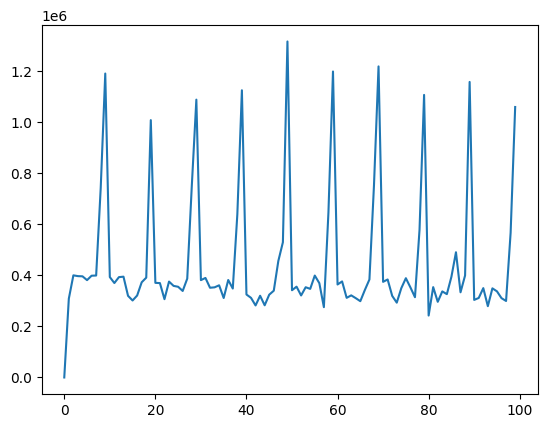

In [66]:
import matplotlib.pyplot as plt 
plt.plot([a[0] for a in size])

In [56]:
pd.read_parquet(file)

,smiles,hs,isocount
0,C1=C[C@@]23C[C@@]45C[C@]2(O1)O[C@@H]4C3=NN5,8,0
1,C1=C[C@@]23C[C@]45C[C@]2(O1)O[C@@H]4C3=NN5,8,0
2,C1=C[C@]23C[C@@]45C[C@]2(O1)O[C@@H]4C3=NN5,8,0
3,C1=C[C@]23C[C@]45C[C@]2(O1)O[C@@H]4C3=NN5,8,0
4,C1=C[C@@]23C[C@@]45C[C@]2(O1)O[C@@H]4C3=NO5,7,1
...,...,...,...
22193,C1=C[C@@]23N[C@H]4[C@H](O[C@H]2O[C@H]14)[C@H]1...,11,5569
22194,C1=C[C@@]23N[C@@H]4[C@H](O[C@@H]2O1)[C@@H]4[C@...,11,5570
22195,C1=C[C@@]23N[C@@H]4[C@H](O[C@@H]2O1)[C@@H]4[C@...,11,5570
22196,C1=C[C@@]23N[C@@H]4[C@H](O[C@@H]2O1)[C@@H]4[C@...,11,5570


In [45]:
df.to_parquet("test.parquet", compression="snappy")

In [48]:
smiles[:100]

array(['C1C23CC45C=COC14OC2C5=NN3', 'C1C23CC45C=COC14OC2C5=NO3',
       'C1C23CC45C=NOC14OC2C5C=C3', 'C1C23CC45C=NOC14OC2C5=CO3',
       'C1C23CC45C=NOC14OC2C5=NN3', 'C1C23CC45C=NOC14OC2C5=NO3',
       'C1C23CC45N=C(NC14C=C2)OC5O3', 'C1C23CC45NN=CC14NC2C5=CO3',
       'C1C23CC45NN=CC14NC2C5=NO3', 'C1C23CC45NN=CC14OC2C5C=C3',
       'C1C23CC45NN=CC14OC2C5=CO3', 'C1C23CC45NN=CC14OC2C5=NN3',
       'C1C23CC45NN=CC14OC2C5=NO3', 'C1C23CC45OC=CC14NC2C5C=C3',
       'C1C23CC45OC=CC14NC2C5=CO3', 'C1C23CC45OC=CC14NC2C5=NN3',
       'C1C23CC45OC=CC14NC2C5=NO3', 'C1C23CC45OC=CC14OC2C5=NN3',
       'C1C23CC45OC=CC14OC2C5=NO3', 'C1C23CC45ON=CC14NC2C5C=C3',
       'C1C23CC45ON=CC14NC2C5=CO3', 'C1C23CC45ON=CC14NC2C5=NN3',
       'C1C23CC45ON=CC14NC2C5=NO3', 'C1C23CC45ON=CC14OC2C5C=C3',
       'C1C23CC45ON=CC14OC2C5=CO3', 'C1C23CC45ON=CC14OC2C5=NN3',
       'C1C23CC45ON=CC14OC2C5=NO3', 'C1C23C=C4C5OC5C1(NC=N2)C4=C3',
       'C1C23CC4(C=C2)N=C2NC14C(O2)O3', 'C1C23C=C4C=CC1(C1OC21)N1C4C31',
       'C1C2

In [47]:
df

,smiles,hs,isocount
0,C1=C[C@@]23C[C@@]45C[C@]2(O1)O[C@@H]4C3=NN5,8,0
1,C1=C[C@@]23C[C@]45C[C@]2(O1)O[C@@H]4C3=NN5,8,0
2,C1=C[C@]23C[C@@]45C[C@]2(O1)O[C@@H]4C3=NN5,8,0
3,C1=C[C@]23C[C@]45C[C@]2(O1)O[C@@H]4C3=NN5,8,0
4,C1=C[C@@]23C[C@@]45C[C@]2(O1)O[C@@H]4C3=NO5,7,1
...,...,...,...
22193,C1=C[C@@]23N[C@H]4[C@H](O[C@H]2O[C@H]14)[C@H]1...,11,5569
22194,C1=C[C@@]23N[C@@H]4[C@H](O[C@@H]2O1)[C@@H]4[C@...,11,5570
22195,C1=C[C@@]23N[C@@H]4[C@H](O[C@@H]2O1)[C@@H]4[C@...,11,5570
22196,C1=C[C@@]23N[C@@H]4[C@H](O[C@@H]2O1)[C@@H]4[C@...,11,5570


In [46]:
!ls -lahS

total 47M
-rw-r--r-- 1 alexm all  47M Apr 15 15:38 13.cno.00.csv.parquet
-rw-r--r-- 1 alexm all 354K Apr 15 15:54 test.parquet
-rw-r--r-- 1 alexm all  47K Apr 15 15:09 sort.ipynb
drwxr-xr-x 5 alexm all   83 Apr 15 15:09 ..
drwxr-xr-x 2 alexm all    3 Apr 15 15:54 .


In [20]:
# count hydrogens and flippers 
# make this into a script and just run it a shit ton of times. 
# flippers are the ones we use to sort before doing somers to have load balancing for parallel processing. 

# all of this string stuff; if we tilejax this basic cheminformatics one IPU could do this 
from rdkit.Chem.EnumerateStereoisomers import * 
from rdkit.Chem.EnumerateStereoisomers import * 

class _BondFlipper(object):

  def __init__(self, bond):
    self.bond = bond

  def flip(self, flag):
    if flag:
      self.bond.SetStereo(Chem.BondStereo.STEREOCIS)
    else:
      self.bond.SetStereo(Chem.BondStereo.STEREOTRANS)


class _AtomFlipper(object):

  def __init__(self, atom):
    self.atom = atom

  def flip(self, flag):
    if flag:
      self.atom.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CW)
    else:
      self.atom.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CCW)


class _StereoGroupFlipper(object):

  def __init__(self, group):
    self._original_parities = [(a, a.GetChiralTag()) for a in group.GetAtoms()]

  def flip(self, flag):
    if flag:
      for a, original_parity in self._original_parities:
        a.SetChiralTag(original_parity)
    else:
      for a, original_parity in self._original_parities:
        if original_parity == Chem.ChiralType.CHI_TETRAHEDRAL_CW:
          a.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CCW)
        elif original_parity == Chem.ChiralType.CHI_TETRAHEDRAL_CCW:
          a.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CW)


def _getFlippers(mol, options):
  Chem.FindPotentialStereoBonds(mol)
  flippers = []
  if not options.onlyStereoGroups:
    for atom in mol.GetAtoms():
      if atom.HasProp("_ChiralityPossible"):
        if (not options.onlyUnassigned or atom.GetChiralTag() == Chem.ChiralType.CHI_UNSPECIFIED):
          flippers.append(_AtomFlipper(atom))

    for bond in mol.GetBonds():
      bstereo = bond.GetStereo()
      if bstereo != Chem.BondStereo.STEREONONE:
        if (not options.onlyUnassigned or bstereo == Chem.BondStereo.STEREOANY):
          flippers.append(_BondFlipper(bond))

  if options.onlyUnassigned:
    # otherwise these will be counted twice
    for group in mol.GetStereoGroups():
      if group.GetGroupType() != Chem.StereoGroupType.STEREO_ABSOLUTE:
        flippers.append(_StereoGroupFlipper(group))

  return flippers
import numpy as np 
options = StereoEnumerationOptions()
def calculate_hs(smile):
    b = Chem.MolFromSmiles(smile)
    b = Chem.AddHs(b)  # this could perhaps directly return hs and be faster because of that? 
    atoms = [atom.GetSymbol() for atom in b.GetAtoms()] 
    hs = len([a for a in atoms if a.upper() == "H"])
    #flippers = _getFlippers(b)
    #return hs, len(flippers)
    return hs

# we also add "num_flippers" where num_isomers =  O( 2** num_flippers )
def _getFlippers(mol):
  Chem.FindPotentialStereoBonds(mol)
  flippers = []
  if not options.onlyStereoGroups:
    for atom in mol.GetAtoms():
      if atom.HasProp("_ChiralityPossible"):
        if (not options.onlyUnassigned or atom.GetChiralTag() == Chem.ChiralType.CHI_UNSPECIFIED):
          flippers.append(_AtomFlipper(atom))

    for bond in mol.GetBonds():
      bstereo = bond.GetStereo()
      if bstereo != Chem.BondStereo.STEREONONE:
        if (not options.onlyUnassigned or bstereo == Chem.BondStereo.STEREOANY):
          flippers.append(_BondFlipper(bond))

  if options.onlyUnassigned:
    # otherwise these will be counted twice
    for group in mol.GetStereoGroups():
      if group.GetGroupType() != Chem.StereoGroupType.STEREO_ABSOLUTE:
        flippers.append(_StereoGroupFlipper(group))
  return flippers

num_hs   = []
num_flips = []
chunk = 1
for i in tqdm(range(0, len(smiles), chunk)): # 100*250 = 25000k/s ; i think this is similar to not using the threads? 
  current   = smiles[i:i+chunk]
  ret       = calculate_hs(current[0]) 
  ret       = np.array(ret).reshape(-1)
  num_hs    = num_hs + ret.tolist()#[::2].tolist()
  #num_flips = num_flips + ret[1::2].tolist() 

print(num_hs) # This takes ~ 1 min for 1/50'th of the data => 2500 seconds = ~ 1 hour. 

  1%|▏         | 76216/5571822 [00:26<32:16, 2837.51it/s]


KeyboardInterrupt: 

In [17]:
import pyscf
from concurrent.futures import ProcessPoolExecutor
import psutil

# Get the number of available processors
num_cpus = psutil.cpu_count(logical=False)

# Get the number of NUMA nodes
num_numa_nodes = psutil.cpu_count()

# Set the number of processes per NUMA node
processes_per_numa_node = num_cpus // num_numa_nodes

# Create a list of NUMA node IDs
numa_node_ids = range(num_numa_nodes)
print(num_cpus)
print(num_numa_nodes)
print(processes_per_numa_node)

120
240
0


In [ ]:
# i think tmux parallelizing is a better option. 
# we just need to add the isomers into it; say max 3 isomers. 

In [ ]:
print(np.shape(num_hs), np.shape(num_flips), len(smiles))

In [8]:
df = pd.DataFrame({"smiles": smiles[:len(num_hs)], "num_hs": np.array(num_hs).reshape(-1)}) # store the one with hydrogen count? 
df.to_parquet("13.cno.00.csv.parquet", compression="snappy")

In [12]:
df=df.sort_values(by="num_hs")
df

,smiles,num_hs
522366,O1N=C2C=C1C#CC#CC#CC#C2,1
3971529,C1C#CC#CC2=NOC3=C2ON=C13,2
3776470,C1C#CC2=NOC(=N2)C2=NOC1=N2,2
3971692,C1C#CC#CC2=NOC3=C2N=NN13,2
3099254,O1N=C2N=C1C=CC#CC#CC#C2,2
...,...,...
4210347,C1CCNCCCOCCCNC1,22
4044277,C1CCCCOCCCNCCC1,23
4021217,C1CCCCNCCOCCCC1,23
4076547,C1CCCNCCCCOCCC1,23


In [14]:
for i in range(2, 23): 
  print(df[df["num_hs"]<i].shape, i)

(1, 2) 2
(56, 2) 3
(335, 2) 4
(3755, 2) 5
(10379, 2) 6
(46239, 2) 7
(108725, 2) 8
(276517, 2) 9
(538753, 2) 10
(956000, 2) 11
(1570801, 2) 12
(2214501, 2) 13
(3187751, 2) 14
(3780130, 2) 15
(4744195, 2) 16
(5063840, 2) 17
(5465644, 2) 18
(5520458, 2) 19
(5568647, 2) 20
(5570506, 2) 21
(5571809, 2) 22


In [ ]:
import matplotlib.pyplot as plt 
plt.plot(np.sort(df["flips"])) # 

In [ ]:
!ls -lahS ## 12 mb, not too bad!  12*50 = 520mb? really, that's pretty amazing! 
df

In [ ]:
df.sort_values(by="flips")

In [ ]:
plt.plot(df["num_hs"].values, df["flips"].values, 'x')

In [ ]:
for i in range(3, 20):
  print(i, df.shape, df[df["num_hs"]<i].shape)

In [1]:
import pandas as pd 
df = pd.read_parquet("12.cno.00.csv.parquet")

sorted_smiles = df[df["num_hs"]<=14].sort_values(by="flips")
print(sorted_smiles)

                               smiles  num_hs  flips
217091          C1CC2(C1)N=CNOC21COC1      12      0
566125            C1NN=C2ON=CCCOC=C12       9      0
1209878         C1OC2=NN3CC=COCC3=C12       8      0
566124           C1CC=NOC2=NN=CC2=CO1       7      0
638054            C1CN2C=NCCC=NN=C2O1      10      0
...                               ...     ...    ...
10806      C1C2C3C4C5C(C6OC6C1N45)N23      10     10
10803      C1C2C3OC3C3C4C5C(C2N34)N15      10     10
10802      C1C2C3OC3C3C4C5C(C1N34)N25      10     10
10800        C1C2C3OC3C3C4C5C2C5C1N34      11     10
1276283  CC12C3C4C5C6C(N6C13)C2(O)C45      11     10

[1139110 rows x 3 columns]


In [2]:
# i think load balancing is the issue; one of the tasks spends aroudn 40-70% and all the others do roughly nothing. 
# this may be caused by inefficient code in the generate isomers.. 
# i starting with gdb9 would be interesting, because we could easily check if the isomers are unique. 
# i guess we can think of the unique ness stuff as not using flops efficiently?

# really looks like load balancing; I wonder how we could fix that? 
# 1. make smaller batches? 
# 2. use dask ( not sure how dask could predict this) 
# 3. limit the number of isomers for each molecule to 20? 
# 4. try to find bottleneck in isomer algorithm 

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from multiprocessing import Pool
from rdkit.Chem import EnumerateStereoisomers
import pandas as pd 
from tqdm import tqdm 


from rdkit.Chem.EnumerateStereoisomers import * 

class _BondFlipper(object):

  def __init__(self, bond):
    self.bond = bond

  def flip(self, flag):
    if flag:
      self.bond.SetStereo(Chem.BondStereo.STEREOCIS)
    else:
      self.bond.SetStereo(Chem.BondStereo.STEREOTRANS)


class _AtomFlipper(object):

  def __init__(self, atom):
    self.atom = atom

  def flip(self, flag):
    if flag:
      self.atom.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CW)
    else:
      self.atom.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CCW)


class _StereoGroupFlipper(object):

  def __init__(self, group):
    self._original_parities = [(a, a.GetChiralTag()) for a in group.GetAtoms()]

  def flip(self, flag):
    if flag:
      for a, original_parity in self._original_parities:
        a.SetChiralTag(original_parity)
    else:
      for a, original_parity in self._original_parities:
        if original_parity == Chem.ChiralType.CHI_TETRAHEDRAL_CW:
          a.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CCW)
        elif original_parity == Chem.ChiralType.CHI_TETRAHEDRAL_CCW:
          a.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CW)


def _getFlippers(mol, options):
  Chem.FindPotentialStereoBonds(mol)
  flippers = []
  if not options.onlyStereoGroups:
    for atom in mol.GetAtoms():
      if atom.HasProp("_ChiralityPossible"):
        if (not options.onlyUnassigned or atom.GetChiralTag() == Chem.ChiralType.CHI_UNSPECIFIED):
          flippers.append(_AtomFlipper(atom))

    for bond in mol.GetBonds():
      bstereo = bond.GetStereo()
      if bstereo != Chem.BondStereo.STEREONONE:
        if (not options.onlyUnassigned or bstereo == Chem.BondStereo.STEREOANY):
          flippers.append(_BondFlipper(bond))

  if options.onlyUnassigned:
    # otherwise these will be counted twice
    for group in mol.GetStereoGroups():
      if group.GetGroupType() != Chem.StereoGroupType.STEREO_ABSOLUTE:
        flippers.append(_StereoGroupFlipper(group))

  return flippers


class _RangeBitsGenerator(object):

  def __init__(self, nCenters):
    self.nCenters = nCenters

  def __iter__(self):
    for val in range(2**self.nCenters):
      yield val


class _UniqueRandomBitsGenerator(object):

  def __init__(self, nCenters, maxIsomers, rand):
    self.nCenters = nCenters
    self.maxIsomers = maxIsomers
    self.rand = rand
    self.already_seen = set()

  def __iter__(self):
    # note: important that this is not 'while True' otherwise it
    # would be possible to have an infinite loop caused by all
    # isomers failing the embedding process
    while len(self.already_seen) < 2**self.nCenters:
      bits = self.rand.getrandbits(self.nCenters)
      if bits in self.already_seen:
        continue

      self.already_seen.add(bits)
      yield bits


def GetStereoisomerCount(m, options=StereoEnumerationOptions()):
  """ returns an estimate (upper bound) of the number of possible stereoisomers for a molecule
   Arguments:
      - m: the molecule to work with
      - options: parameters controlling the enumeration
    >>> from rdkit import Chem
    >>> from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions
    >>> m = Chem.MolFromSmiles('BrC(Cl)(F)CCC(O)C')
    >>> GetStereoisomerCount(m)
    4
    >>> m = Chem.MolFromSmiles('CC(Cl)(O)C')
    >>> GetStereoisomerCount(m)
    1
    double bond stereochemistry is also included:
    >>> m = Chem.MolFromSmiles('BrC(Cl)(F)C=CC(O)C')
    >>> GetStereoisomerCount(m)
    8
    """
  tm = Chem.Mol(m)
  flippers = _getFlippers(tm, options)
  return 2**len(flippers)


# benchmark this script, which parts of it take time? 
def CustomEnumerateStereoisomers(m, max=100, options=StereoEnumerationOptions(), verbose=False):
  # it takes linearly longer in the number of isomers; so the stuff that takes time in num_atoms/num_bonds 
  # is likely not dominating! 

  tm = Chem.MolFromSmiles(m)
  for atom in tm.GetAtoms(): # loop through atoms 
    atom.ClearProp("_CIPCode")
  for bond in tm.GetBonds(): # loop through bonds 
    if bond.GetBondDir() == Chem.BondDir.EITHERDOUBLE:
      bond.SetBondDir(Chem.BondDir.NONE)
  flippers = _getFlippers(tm, options)
  nCenters = len(flippers)
  if not nCenters:
    yield tm
    return

  #q: what does it use the random bits for? can we generate these with numpy and pass as input? perhaps that's the bottleneck? 

  if (options.maxIsomers == 0 or 2**nCenters <= options.maxIsomers):
    bitsource = _RangeBitsGenerator(nCenters)
  else:
    if options.rand is None:
      # deterministic random seed invariant to input atom order
      seed = hash(tuple(sorted([(a.GetDegree(), a.GetAtomicNum()) for a in tm.GetAtoms()])))
      rand = random.Random(seed)
    elif isinstance(options.rand, random.Random):
      # other implementations of Python random number generators
      # can inherit from this class to pick up utility methods
      rand = options.rand
    else:
      rand = random.Random(options.rand)
    bitsource = _UniqueRandomBitsGenerator(nCenters, options.maxIsomers, rand)

  isomersSeen = set()
  numIsomers = 0

  for bitflag in bitsource:
    for i in range(nCenters):
      flag = bool(bitflag & (1 << i))
      flippers[i].flip(flag)

    # from this point on we no longer need the stereogroups (if any are there), so
    # remove them:
    if tm.GetStereoGroups():
      isomer = Chem.RWMol(tm)
      isomer.SetStereoGroups([])
    else:
      isomer = Chem.Mol(tm)
    Chem.SetDoubleBondNeighborDirections(isomer)
    isomer.ClearComputedProps(includeRings=False)

    Chem.AssignStereochemistry(isomer, cleanIt=True, force=True, flagPossibleStereoCenters=True)
    if options.unique:
      cansmi = Chem.MolToSmiles(isomer, isomericSmiles=True)
      if cansmi in isomersSeen:
        continue

      isomersSeen.add(cansmi)

    if options.tryEmbedding:
      ntm = Chem.AddHs(isomer)
      # mask bitflag to fit within C++ int.
      cid = EmbedMolecule(ntm, randomSeed=(bitflag & 0x7fffffff))
      if cid >= 0:
        conf = Chem.Conformer(isomer.GetNumAtoms())
        for aid in range(isomer.GetNumAtoms()):
          conf.SetAtomPosition(aid, ntm.GetConformer().GetAtomPosition(aid))
        isomer.AddConformer(conf)
    else:
      cid = 1
    if cid >= 0:
      yield isomer
      numIsomers += 1
      if options.maxIsomers != 0 and numIsomers >= options.maxIsomers or numIsomers > max:
        break
    elif verbose:
      print("%s    failed to embed" % (Chem.MolToSmiles(isomer, isomericSmiles=True)))


# sorting by flips improves load balancing 
def calculate_mol_descriptors(smile): 
    isomers = CustomEnumerateStereoisomers(smile, max=100)  # we could use max=100 perhaps?
    isomer_smiles = [Chem.MolToSmiles(isomer, isomericSmiles=True) for isomer in isomers]# perhaps it's the MolToSmiles?
    return [smile] + isomer_smiles, 0 

num_hs        = []
isomer_smiles = []
num_flips = []
isomer_num = []

from tqdm.notebook import tqdm 

c= 0 
with Pool() as p:
  chunk = 100 
  pbar = tqdm(range(0, len(sorted_smiles), chunk))
  for num, i in enumerate(pbar):
    current = sorted_smiles["smiles"].values[i:i+chunk]
    current_hs = sorted_smiles["num_hs"].values[i:i+chunk]
    current_flips = sorted_smiles["flips"].values[i:i+chunk]
    ret = p.map(calculate_mol_descriptors, current) 
    smile = []
    hs = []
    flips = []
    isonum = []
    # seems isomer algorithm uses random bits to get good cover of space. 
    for j, (a,b) in enumerate(ret): 
      smile = smile + a
      hs = hs + [current_hs[j]]*len(a)
      flips = flips + [current_flips[j]]*len(a)
      isonum = isonum + [c]*len(a) # count number of initial molecules, the isomers will have the same number here! 
      c+=1
    isomer_smiles = isomer_smiles + smile 
    num_hs        = num_hs + hs 
    num_flips     = num_flips + flips 
    isomer_num     = isomer_num + isonum

    if num % 100 == 0: pbar.set_description("isomers=%10i num=%10i"%((len(isomer_smiles), i)))

print(num_hs) # holy shit it works! the load balancing helped a s hit ton! oh no, only for the first ones.. 

# 20M ;; 1M => 20M 
# this means 20M * 50 == 1B; so it actually would work, most of it would just be isomers which is a bit weird. 
# it kind of introduces some dependency between the molecule, so we'd preferably try to split them on this? 

  0%|          | 0/11392 [00:00<?, ?it/s]

In [11]:
print(len(isomer_num), len(num_hs))

114000 228000


In [1]:
# This is already so this may become 30M ? if so
import pandas as pd 
isomers = pd.DataFrame({"smile": isomer_smiles, "num_hs": num_hs, "flips": num_flips, "isomer_num": isomer_num }) # how do we annotate isomers?
print(isomers.shape)
isomers

NameError: name 'pd' is not defined

In [ ]:
plt.plot(df["num_hs"]) # holy fucking shit this is perfect. 

In [ ]:
df

# store with all isomers (and hydrogens) 
pd.DataFrame({})

In [ ]:
!pip install dask

In [ ]:
import dask
from dask import delayed
from rdkit import Chem
from rdkit.Chem import EnumerateStereoisomers

def generate_stereoisomers(smiles):
    mol = Chem.MolFromSmiles(smiles)
    #isomer_options = EnumerateStereoisomers.EnumerateStereoisomersOptions(unique=True)
    isomers = EnumerateStereoisomers.EnumerateStereoisomers(mol)#, options=isomer_options)
    isomer_smiles = [Chem.MolToSmiles(isomer, isomericSmiles=True) for isomer in isomers]
    return isomer_smiles

smiles_list = [
    "CC(=O)Oc1ccccc1C(=O)O",  # Aspirin
    "CCN(CC)C(=S)SSC(=S)N(CC)CC",  # Thiomersal
    "C1CCCCC1",  # Cyclohexane
]
# creating tasks 
tasks = [delayed(generate_stereoisomers)(smile) for smile in tqdm(smiles)]

# running all tasks 
for i in tqdm(range(0, len(smiles), 240)):
    task = tasks[i:i+240]

    # Compute the results in parallel
    results = dask.compute(*task)


In [ ]:
print(len(isomer_smiles))

In [ ]:
a = np.unique(isomer_smiles)
print(a.shape) # not issue with unique ness so far. 

In [ ]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots()
plt.plot(num_hs, 'x', alpha=0.1)

fig, ax = plt.subplots()
unique, counts = np.unique(num_hs, return_counts=True)
plt.plot(counts)

In [ ]:
import numpy as np 
unique_num_hs = np.unique(num_hs)
print(unique_num_hs.shape, num_hs.shape, smiles.shape)
print(unique_num_hs[:5], num_hs[:5])
print(unique_num_hs.sum(), np.sum(num_hs))
assert np.allclose(unique_num_hs , np.array(num_hs))

In [ ]:
import numpy as np 
sorted = smiles[np.argsort(num_hs)]
print(sorted)

In [ ]:
srt = []
with_isomers = []
pbar = tqdm(sorted[:10240])
for smile in pbar: 
    from rdkit.Chem import EnumerateStereoisomers

    atoms = [a for a in list(smile.upper()) if a == "C" or a == "N" or a == "O" or a == "F"]
    #if len(atoms) != 10: return -1 
    b = Chem.MolFromSmiles(smile)
    b = Chem.AddHs(b) 
    atoms = [atom.GetSymbol() for atom in b.GetAtoms()]
    hs = len([a for a in atoms if a.upper() == "H"])
    #pbar.set_description(hs)
    isomers = EnumerateStereoisomers.EnumerateStereoisomers(b)
    isomer_smiles = [Chem.MolToSmiles(isomer, isomericSmiles=True) for isomer in isomers]

    # isomers should have the same number of hydrogens! 
    # if this fails it just means we sorted poorly, and we'll have ot compile more.

    #for s in [smile] + isomer_smiles: 
    #    b = Chem.MolFromSmiles(s)
    #
    #        srt.append(hs)


In [ ]:

import matplotlib.pyplot as plt 
plt.plot(srt)

In [ ]:
import matplotlib.pyplot as plt 
plt.plot(srt)

In [ ]:
### 

In [ ]:

from rdkit.Chem.EnumerateStereoisomers import * 


class _BondFlipper(object):

  def __init__(self, bond):
    self.bond = bond

  def flip(self, flag):
    if flag:
      self.bond.SetStereo(Chem.BondStereo.STEREOCIS)
    else:
      self.bond.SetStereo(Chem.BondStereo.STEREOTRANS)


class _AtomFlipper(object):

  def __init__(self, atom):
    self.atom = atom

  def flip(self, flag):
    if flag:
      self.atom.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CW)
    else:
      self.atom.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CCW)


class _StereoGroupFlipper(object):

  def __init__(self, group):
    self._original_parities = [(a, a.GetChiralTag()) for a in group.GetAtoms()]

  def flip(self, flag):
    if flag:
      for a, original_parity in self._original_parities:
        a.SetChiralTag(original_parity)
    else:
      for a, original_parity in self._original_parities:
        if original_parity == Chem.ChiralType.CHI_TETRAHEDRAL_CW:
          a.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CCW)
        elif original_parity == Chem.ChiralType.CHI_TETRAHEDRAL_CCW:
          a.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CW)


def _getFlippers(mol, options):
  Chem.FindPotentialStereoBonds(mol)
  flippers = []
  if not options.onlyStereoGroups:
    for atom in mol.GetAtoms():
      if atom.HasProp("_ChiralityPossible"):
        if (not options.onlyUnassigned or atom.GetChiralTag() == Chem.ChiralType.CHI_UNSPECIFIED):
          flippers.append(_AtomFlipper(atom))

    for bond in mol.GetBonds():
      bstereo = bond.GetStereo()
      if bstereo != Chem.BondStereo.STEREONONE:
        if (not options.onlyUnassigned or bstereo == Chem.BondStereo.STEREOANY):
          flippers.append(_BondFlipper(bond))

  if options.onlyUnassigned:
    # otherwise these will be counted twice
    for group in mol.GetStereoGroups():
      if group.GetGroupType() != Chem.StereoGroupType.STEREO_ABSOLUTE:
        flippers.append(_StereoGroupFlipper(group))

  return flippers


class _RangeBitsGenerator(object):

  def __init__(self, nCenters):
    self.nCenters = nCenters

  def __iter__(self):
    for val in range(2**self.nCenters):
      yield val


class _UniqueRandomBitsGenerator(object):

  def __init__(self, nCenters, maxIsomers, rand):
    self.nCenters = nCenters
    self.maxIsomers = maxIsomers
    self.rand = rand
    self.already_seen = set()

  def __iter__(self):
    # note: important that this is not 'while True' otherwise it
    # would be possible to have an infinite loop caused by all
    # isomers failing the embedding process
    while len(self.already_seen) < 2**self.nCenters:
      bits = self.rand.getrandbits(self.nCenters)
      if bits in self.already_seen:
        continue

      self.already_seen.add(bits)
      yield bits


def GetStereoisomerCount(m, options=StereoEnumerationOptions()):
  """ returns an estimate (upper bound) of the number of possible stereoisomers for a molecule
   Arguments:
      - m: the molecule to work with
      - options: parameters controlling the enumeration
    >>> from rdkit import Chem
    >>> from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions
    >>> m = Chem.MolFromSmiles('BrC(Cl)(F)CCC(O)C')
    >>> GetStereoisomerCount(m)
    4
    >>> m = Chem.MolFromSmiles('CC(Cl)(O)C')
    >>> GetStereoisomerCount(m)
    1
    double bond stereochemistry is also included:
    >>> m = Chem.MolFromSmiles('BrC(Cl)(F)C=CC(O)C')
    >>> GetStereoisomerCount(m)
    8
    """
  tm = Chem.Mol(m)
  flippers = _getFlippers(tm, options) # so it's exponential in the number of flippers. ;; so sort by number of flippers? 
  return 2**len(flippers)


# benchmark this script, which parts of it take time? 
def EnumerateStereoisomers(m, max=100, options=StereoEnumerationOptions(), verbose=False):
  # it takes linearly longer in the number of isomers; so the stuff that takes time in num_atoms/num_bonds 
  # is likely not dominating! 

  tm = Chem.MolFromSmiles(m)
  for atom in tm.GetAtoms(): # loop through atoms 
    atom.ClearProp("_CIPCode")
  for bond in tm.GetBonds(): # loop through bonds 
    if bond.GetBondDir() == Chem.BondDir.EITHERDOUBLE:
      bond.SetBondDir(Chem.BondDir.NONE)
  flippers = _getFlippers(tm, options)
  nCenters = len(flippers)
  if not nCenters:
    yield tm
    return

  #q: what does it use the random bits for? can we generate these with numpy and pass as input? perhaps that's the bottleneck? 

  if (options.maxIsomers == 0 or 2**nCenters <= options.maxIsomers):
    bitsource = _RangeBitsGenerator(nCenters)
  else:
    if options.rand is None:
      # deterministic random seed invariant to input atom order
      seed = hash(tuple(sorted([(a.GetDegree(), a.GetAtomicNum()) for a in tm.GetAtoms()])))
      rand = random.Random(seed)
    elif isinstance(options.rand, random.Random):
      # other implementations of Python random number generators
      # can inherit from this class to pick up utility methods
      rand = options.rand
    else:
      rand = random.Random(options.rand)
    bitsource = _UniqueRandomBitsGenerator(nCenters, options.maxIsomers, rand)

  isomersSeen = set()
  numIsomers = 0
  
  for bitflag in bitsource:
    for i in range(nCenters):
      flag = bool(bitflag & (1 << i))
      flippers[i].flip(flag)

    # from this point on we no longer need the stereogroups (if any are there), so
    # remove them:
    if tm.GetStereoGroups():
      isomer = Chem.RWMol(tm)
      isomer.SetStereoGroups([])
    else:
      isomer = Chem.Mol(tm)
    Chem.SetDoubleBondNeighborDirections(isomer)
    isomer.ClearComputedProps(includeRings=False)

    Chem.AssignStereochemistry(isomer, cleanIt=True, force=True, flagPossibleStereoCenters=True)
    if options.unique:
      cansmi = Chem.MolToSmiles(isomer, isomericSmiles=True)
      if cansmi in isomersSeen:
        continue

      isomersSeen.add(cansmi)

    if options.tryEmbedding:
      ntm = Chem.AddHs(isomer)
      # mask bitflag to fit within C++ int.
      cid = EmbedMolecule(ntm, randomSeed=(bitflag & 0x7fffffff))
      if cid >= 0:
        conf = Chem.Conformer(isomer.GetNumAtoms())
        for aid in range(isomer.GetNumAtoms()):
          conf.SetAtomPosition(aid, ntm.GetConformer().GetAtomPosition(aid))
        isomer.AddConformer(conf)
    else:
      cid = 1
    if cid >= 0:
      yield isomer
      numIsomers += 1
      if options.maxIsomers != 0 and numIsomers >= options.maxIsomers or numIsomers > max:
        break
    elif verbose:
      print("%s    failed to embed" % (Chem.MolToSmiles(isomer, isomericSmiles=True)))


smile = df["smiles"].values[123467]
#smile = "C1CC1C1NCC#CCON=C1"
times = []
isomers = []
import time 

pbar = tqdm(df["smiles"].values[::1024])
for smile in pbar:

  t0 = time.time()

  _isomers = EnumerateStereoisomers(smile)
  t1 = time.time()
  isomer_smiles = [Chem.MolToSmiles(isomer, isomericSmiles=True) for isomer in _isomers]
  t2 = time.time()

  #print(t2-t1, t1-t0)
  times.append(t2-t1)
  isomers.append(len(isomer_smiles))

  pbar.set_description("%f %i"%(times[-1], isomers[-1]))



In [ ]:
plt.plot(times, isomers, 'x') # after fixing max number of isomers to 100

In [ ]:
plt.plot(times, isomers, 'x')
# so larger number of isomers => longer time to do => harder to parallelize (unless we can sort by this, but not sure how to do that? )

In [26]:

from rdkit.Chem.EnumerateStereoisomers import * 

class _BondFlipper(object):

  def __init__(self, bond):
    self.bond = bond

  def flip(self, flag):
    if flag:
      self.bond.SetStereo(Chem.BondStereo.STEREOCIS)
    else:
      self.bond.SetStereo(Chem.BondStereo.STEREOTRANS)


class _AtomFlipper(object):

  def __init__(self, atom):
    self.atom = atom

  def flip(self, flag):
    if flag:
      self.atom.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CW)
    else:
      self.atom.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CCW)


class _StereoGroupFlipper(object):

  def __init__(self, group):
    self._original_parities = [(a, a.GetChiralTag()) for a in group.GetAtoms()]

  def flip(self, flag):
    if flag:
      for a, original_parity in self._original_parities:
        a.SetChiralTag(original_parity)
    else:
      for a, original_parity in self._original_parities:
        if original_parity == Chem.ChiralType.CHI_TETRAHEDRAL_CW:
          a.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CCW)
        elif original_parity == Chem.ChiralType.CHI_TETRAHEDRAL_CCW:
          a.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CW)


def _getFlippers(mol, options):
  Chem.FindPotentialStereoBonds(mol)
  flippers = []
  if not options.onlyStereoGroups:
    for atom in mol.GetAtoms():
      if atom.HasProp("_ChiralityPossible"):
        if (not options.onlyUnassigned or atom.GetChiralTag() == Chem.ChiralType.CHI_UNSPECIFIED):
          flippers.append(_AtomFlipper(atom))

    for bond in mol.GetBonds():
      bstereo = bond.GetStereo()
      if bstereo != Chem.BondStereo.STEREONONE:
        if (not options.onlyUnassigned or bstereo == Chem.BondStereo.STEREOANY):
          flippers.append(_BondFlipper(bond))

  if options.onlyUnassigned:
    # otherwise these will be counted twice
    for group in mol.GetStereoGroups():
      if group.GetGroupType() != Chem.StereoGroupType.STEREO_ABSOLUTE:
        flippers.append(_StereoGroupFlipper(group))

  return flippers


class _RangeBitsGenerator(object):

  def __init__(self, nCenters):
    self.nCenters = nCenters

  def __iter__(self):
    for val in range(2**self.nCenters):
      yield val


class _UniqueRandomBitsGenerator(object):

  def __init__(self, nCenters, maxIsomers, rand):
    self.nCenters = nCenters
    self.maxIsomers = maxIsomers
    self.rand = rand
    self.already_seen = set()

  def __iter__(self):
    # note: important that this is not 'while True' otherwise it
    # would be possible to have an infinite loop caused by all
    # isomers failing the embedding process
    while len(self.already_seen) < 2**self.nCenters:
      bits = self.rand.getrandbits(self.nCenters)
      if bits in self.already_seen:
        continue

      self.already_seen.add(bits)
      yield bits


def GetStereoisomerCount(m, options=StereoEnumerationOptions()):
  """ returns an estimate (upper bound) of the number of possible stereoisomers for a molecule
   Arguments:
      - m: the molecule to work with
      - options: parameters controlling the enumeration
    >>> from rdkit import Chem
    >>> from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions
    >>> m = Chem.MolFromSmiles('BrC(Cl)(F)CCC(O)C')
    >>> GetStereoisomerCount(m)
    4
    >>> m = Chem.MolFromSmiles('CC(Cl)(O)C')
    >>> GetStereoisomerCount(m)
    1
    double bond stereochemistry is also included:
    >>> m = Chem.MolFromSmiles('BrC(Cl)(F)C=CC(O)C')
    >>> GetStereoisomerCount(m)
    8
    """
  tm = Chem.Mol(m)
  flippers = _getFlippers(tm, options)
  return 2**len(flippers)


# benchmark this script, which parts of it take time? 
def CustomEnumerateStereoisomers(m, max=3, options=StereoEnumerationOptions(), verbose=False):
  # it takes linearly longer in the number of isomers; so the stuff that takes time in num_atoms/num_bonds 
  # is likely not dominating! 
  tm = Chem.MolFromSmiles(m)

  for atom in tm.GetAtoms(): # loop through atoms 
    atom.ClearProp("_CIPCode")
  for bond in tm.GetBonds(): # loop through bonds 
    if bond.GetBondDir() == Chem.BondDir.EITHERDOUBLE:
      bond.SetBondDir(Chem.BondDir.NONE)
  flippers = _getFlippers(tm, options)
  nCenters = len(flippers)
  if not nCenters:
    yield tm
    return

  #q: what does it use the random bits for? can we generate these with numpy and pass as input? perhaps that's the bottleneck? 

  if (options.maxIsomers == 0 or 2**nCenters <= options.maxIsomers):
    bitsource = _RangeBitsGenerator(nCenters)
  else:
    if options.rand is None:
      # deterministic random seed invariant to input atom order
      seed = hash(tuple(sorted([(a.GetDegree(), a.GetAtomicNum()) for a in tm.GetAtoms()])))
      rand = random.Random(seed)
    elif isinstance(options.rand, random.Random):
      # other implementations of Python random number generators
      # can inherit from this class to pick up utility methods
      rand = options.rand
    else:
      rand = random.Random(options.rand)
    bitsource = _UniqueRandomBitsGenerator(nCenters, options.maxIsomers, rand)

  isomersSeen = set()
  numIsomers = 0

  for bitflag in bitsource:
    for i in range(nCenters):
      flag = bool(bitflag & (1 << i))
      flippers[i].flip(flag)

    # from this point on we no longer need the stereogroups (if any are there), so
    # remove them:
    if tm.GetStereoGroups():
      isomer = Chem.RWMol(tm)
      isomer.SetStereoGroups([])
    else:
      isomer = Chem.Mol(tm)
    Chem.SetDoubleBondNeighborDirections(isomer)
    isomer.ClearComputedProps(includeRings=False)

    Chem.AssignStereochemistry(isomer, cleanIt=True, force=True, flagPossibleStereoCenters=True)
    if options.unique:
      cansmi = Chem.MolToSmiles(isomer, isomericSmiles=True)
      if cansmi in isomersSeen:
        continue

      isomersSeen.add(cansmi)

    if options.tryEmbedding:
      ntm = Chem.AddHs(isomer)
      # mask bitflag to fit within C++ int.
      cid = EmbedMolecule(ntm, randomSeed=(bitflag & 0x7fffffff))
      if cid >= 0:
        conf = Chem.Conformer(isomer.GetNumAtoms())
        for aid in range(isomer.GetNumAtoms()):
          conf.SetAtomPosition(aid, ntm.GetConformer().GetAtomPosition(aid))
        isomer.AddConformer(conf)
    else:
      cid = 1
    if cid >= 0:
      yield isomer
      numIsomers += 1
      if options.maxIsomers != 0 and numIsomers >= options.maxIsomers or numIsomers > max:
        break
    elif verbose:
      print("%s    failed to embed" % (Chem.MolToSmiles(isomer, isomericSmiles=True)))


smile = df["smiles"].values[123467]
#smile = "C1CC1C1NCC#CCON=C1"
times = []
isomers = []
import time 


t0 = time.time()

_isomers = CustomEnumerateStereoisomers(smile)
t1 = time.time()
isomer_smiles = [Chem.MolToSmiles(isomer, isomericSmiles=True) for isomer in _isomers]
t2 = time.time()

#print(t2-t1, t1-t0)
times.append(t2-t1)
isomers.append(len(isomer_smiles))

print(times)
print(isomer_smiles)



[0.0014848709106445312]
['C1=C[C@H]2C[C@@H]3[C@@H](O1)c1nn[nH]c1N32', 'C1=C[C@@H]2C[C@@H]3[C@@H](O1)c1nn[nH]c1N23', 'C1=C[C@H]2C[C@@H]3[C@H](O1)c1nn[nH]c1N32', 'C1=C[C@@H]2C[C@@H]3[C@H](O1)c1nn[nH]c1N23']
